<a href="https://colab.research.google.com/github/carloslme/brewing-data/blob/main/Notes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Notas


**Problemas probables:**
- Estimar la demanda de cada uno de los puntos
- Minimizar las entregas
- Crear seis clusters a partir de la ubicación 
- Zonas de peligro (variables de riesgo)
- Variables de consumo promedio
- Capacidades del distribuidor
- Consumo/gasto de combustible
- Pedidos por temporada (demanda)
- Riesgos de 

**Soluciones:**
Encontrar similitudes entre territorios
> Dijkstra
- Minimización de recorrido (buscar algoritmos con ML)
- Maximización de reparto (buscar algoritmos con ML)



**Preguntas**
- ¿Cómo las empresas de entrega de paquetes gestionan la logística de distribución?
- ¿Cómo se distribuye la Coca-Cola/Pepsi/Bimbo en México?
- ¿Cuáles son los mayores retos acutales y cómo los resuelven?
- ¿Cómo miden el consumo promedio?
- 

**Reglas**
- Un centro de distribción dividido en 6 territorios
- Entregar 1 territorio cada día (6 días laborables)
- Garantizar que la distancia recorrida sea mínima
- No exceder la capacidad de reparto por día (zonas balanceadas por volumen).
- Los territorios deben estar en función de la frecuencia de visita al cliente
- Todos los territorios deben tener la misma cantidad de clientes (zonas balanceadas por número de clientes).
- Reducir los tiempos de entrega (considerar recorridos dinámicos en clusters de tipo urbano).
- 


**Notas de Julio**
"lo que dices está bien, se me ocurren un par de cosas más que probar. No te quiero sesgar, solo ofrecerte más ideas, igual y se te ocurre algo mejor:
si tienes la ubicaciones de los clientes, y tienes que repartir en periodos de 6 días, crear 6 clusters a partir de la ubicación, luego dentro de los clusters resultantes estimar la demanda con un intervalo de confianza (evitar sub abasto)
si tienes la ubicaciones de tus clientes, u resuelves como agruparlos implementar algoritmo de ruta más corta
si se me ocurre algo más, te aviso. También si te hacen llegar el data set, se vuelve más fácil proponer"

"y luego sobre los clusters calcular la suma de la demanda historica, mas algo basado en la desviacion para garantizar que siempre les vas a abastecer, y finalmente algoritmo de Dijkstra sobre cada uno de los 6 clusters para crear la ruta"


In [ ]:
https://medium.com/@aaronhma/hands-on-ml-edition-2-by-aerolien-geron-summary-part-1-546617adfcc7
https://www.kaggle.com/ghoshsaptarshi/av-genpact-hack-dec2018


#Obtención de datos

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import seaborn as _sns
import matplotlib.pyplot as plt

data = pd.DataFrame()
def load_data(): 

  data = pd.read_csv("https://raw.githubusercontent.com/brewing-datacup/reto-mexico-2020/main/data/ubicaciones.csv")

  data['Vol_Total_Entrega'] = data['Vol_Entrega'] * data['Frecuencia']
  #ax = sns.boxplot(x = data["Frecuencia"], y = data["Vol_Total_Entrega"])
  return data

# Analisis de los datos

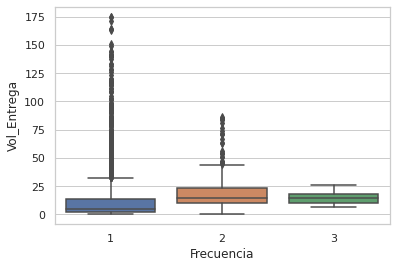

In [ ]:
sns.set_theme(style="whitegrid")
ax = sns.boxplot(x = data["Frecuencia"], y = data["Vol_Entrega"])

,Id_Cliente,id_Agencia,Frecuencia,Vol_Entrega,lat,lon,Vol_Total_Entrega
0,1,A1,1,2.0,20.506052,-98.212377,2.0
1,2,A1,1,17.0,20.458128,-98.221248,17.0
2,3,A1,1,2.0,20.530427,-98.236860,2.0
3,4,A1,3,15.0,20.488655,-98.202940,45.0
4,5,A1,1,2.0,20.533253,-98.219669,2.0


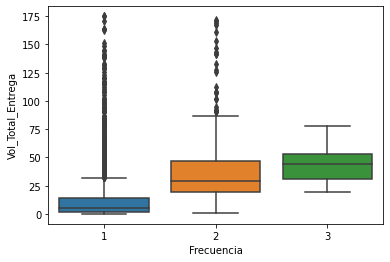

In [ ]:
data['Vol_Total_Entrega'] = data['Vol_Entrega'] * data['Frecuencia']
ax = sns.boxplot(x = data["Frecuencia"], y = data["Vol_Total_Entrega"])
data.head(5)

Text(0.5, 1.0, 'Vol Total Entrega')

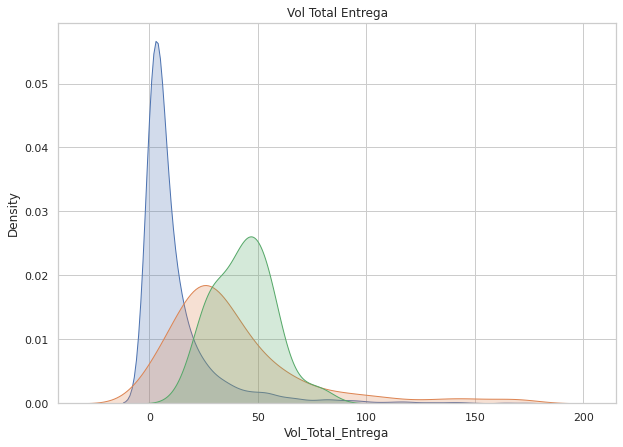

In [ ]:
plt.figure(figsize = (10, 7))

sns.kdeplot(data.loc[ data['Frecuencia'] == 1 , 'Vol_Total_Entrega'], label = 'Freq1', shade = True)
sns.kdeplot(data.loc[ data['Frecuencia'] == 2 , 'Vol_Total_Entrega'], label = 'Freq2', shade = True)
sns.kdeplot(data.loc[ data['Frecuencia'] == 3 , 'Vol_Total_Entrega'], label = 'Freq3', shade = True)

plt.xlabel('Vol_Total_Entrega')
plt.title('Vol Total Entrega')

In [ ]:
data.head(5)

,Id_Cliente,id_Agencia,Frecuencia,Vol_Entrega,lat,lon,Vol_Total_Entrega
0,1,A1,1,2.0,20.506052,-98.212377,2.0
1,2,A1,1,17.0,20.458128,-98.221248,17.0
2,3,A1,1,2.0,20.530427,-98.236860,2.0
3,4,A1,3,15.0,20.488655,-98.202940,45.0
4,5,A1,1,2.0,20.533253,-98.219669,2.0


# Preprocesamiento de datos


### Removiendo outliers

[INFO] Dataset size: (3625, 7)


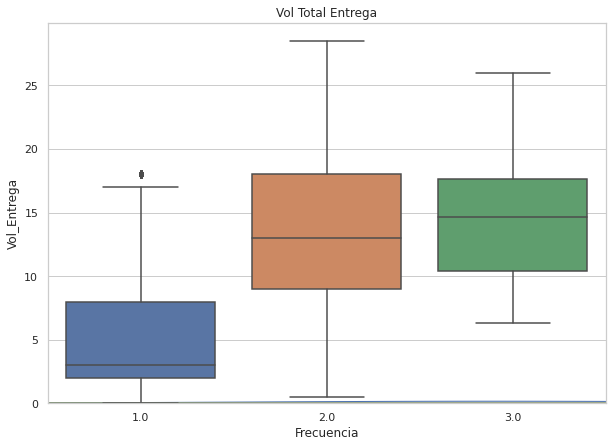

In [ ]:
# filter_1 = data[data['Frecuencia'] == 1]


def remove_outlier(data, range=1.5, debug=False):
  var = ['Vol_Total_Entrega', 'Vol_Entrega']

  filter01 = data['Frecuencia'] == 1
  p_25_freq_1 = data[filter01][var].quantile(0.25)
  p_75_freq_1 = data[filter01][var].quantile(0.75)

  filter02 = data['Frecuencia'] == 2
  p_25_freq_2 = data[filter02][var].quantile(0.25)
  p_75_freq_2 = data[filter02][var].quantile(0.75)

  filter03 = data['Frecuencia'] == 3
  p_25_freq_3 = data[filter03][var].quantile(0.25)
  p_75_freq_3 = data[filter03][var].quantile(0.75)

  IQR_freq_1 = p_75_freq_1 - p_25_freq_1
  IQR_freq_2 = p_75_freq_2 - p_25_freq_2
  IQR_freq_3 = p_75_freq_3 - p_25_freq_3

  low_freq_1 = p_25_freq_1 - 1.5 * IQR_freq_1
  high_freq_1 = p_75_freq_1 + range * IQR_freq_1 

  low_freq_2 = p_25_freq_2 - 1.5 * IQR_freq_2
  high_freq_2 = p_75_freq_2 + range * IQR_freq_2

  low_freq_3 = p_25_freq_3 - 1.5 * IQR_freq_3
  high_freq_3 = p_75_freq_3 + 1.5 * IQR_freq_3

  data[filter01] = data[filter01][~((data[filter01].loc[:,var] < (low_freq_1)) | (data[filter01].loc[:,var] > (high_freq_1))).any(axis=1)]
  data[filter02] = data[filter02][~((data[filter02].loc[:,var] < (low_freq_2)) | (data[filter02].loc[:,var] > (high_freq_2))).any(axis=1)]
  data[filter03] = data[filter03][~((data[filter03].loc[:,var] < (low_freq_3)) | (data[filter03].loc[:,var] > (high_freq_3))).any(axis=1)]
  
  print('[INFO] Dataset size:', data.shape)

  plt.figure(figsize = (10, 7))

  sns.kdeplot(data.loc[data['Frecuencia'] == 1 , 'Vol_Total_Entrega'], label = 'Freq1', shade = True)
  sns.kdeplot(data.loc[data['Frecuencia'] == 2 , 'Vol_Total_Entrega'], label = 'Freq2', shade = True)
  sns.kdeplot(data.loc[data['Frecuencia'] == 3 , 'Vol_Total_Entrega'], label = 'Freq3', shade = True)

  plt.xlabel('Vol_Total_Entrega')
  plt.title('Vol Total Entrega')
  
  def plot_outlier(data):
    sns.set_theme(style="whitegrid")
    ax = sns.boxplot(x = data["Frecuencia"], y = data["Vol_Entrega"])
  
  if debug:
    plot_outlier(data)

for i in range(0,1):
  data = load_data()
  remove_outlier(data, range = 0.4, debug=True)
#remove_outlier(data, range=2)

In [ ]:
data.dropna()

,Id_Cliente,id_Agencia,Frecuencia,Vol_Entrega,lat,lon,Vol_Total_Entrega
0,1.0,A1,1.0,2.0,20.506052,-98.212377,2.0
1,2.0,A1,1.0,17.0,20.458128,-98.221248,17.0
2,3.0,A1,1.0,2.0,20.530427,-98.236860,2.0
3,4.0,A1,3.0,15.0,20.488655,-98.202940,45.0
4,5.0,A1,1.0,2.0,20.533253,-98.219669,2.0
...,...,...,...,...,...,...,...
3619,3620.0,A1,1.0,1.0,20.511046,-98.203215,1.0
3620,3621.0,A1,1.0,15.0,20.558651,-98.149706,15.0
3621,3622.0,A1,1.0,2.0,20.541300,-98.157300,2.0
3622,3623.0,A1,1.0,6.0,20.509200,-98.128000,6.0


### División del conjunto de datos

In [ ]:
data.head(5)

,Id_Cliente,id_Agencia,Frecuencia,Vol_Entrega,lat,lon,Vol_Total_Entrega
0,1,A1,1,2.0,20.506052,-98.212377,2.0
1,2,A1,1,17.0,20.458128,-98.221248,17.0
2,3,A1,1,2.0,20.530427,-98.236860,2.0
4,5,A1,1,2.0,20.533253,-98.219669,2.0
5,6,A1,1,19.0,20.531060,-98.182642,19.0


In [ ]:

# 
X = dataset.iloc[:, :-1].values 
y = dataset.iloc[:, 3].values 


# Dividir el data set en conjunto de entrenamiento y en conjunto de testing
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size = 0.2, random_state = 0)

### Escalamiento de variables

In [ ]:
# Escalado de variables
from sklearn.preprocessing import StandardScaler
sc_X = StandardScaler()
data = sc_X.fit_transform(data['Frecuencia']=1)
X_test = sc_X.transform(X_test)